## 분석절차
1. EDA 
  - target 피쳐 확인/분리
  - info(), shape, head() - dataframe 타입별(수치형/object) 

2. 결측치 확인(1.삭제 2.대체값 3.예측)
  - 결측값 대체(수치형:평균 / Object형:'None')
  - 확인방법 : Boxplot, hist, IQR
  
3. 차트 그리기 준비 작업
  - Object형 시각화 --> 필요 시 수치형으로 변환
  - unique ID 피쳐 삭제
  
4. 불피요한 피쳐 삭제
  
5. 피쳐 전처리(PreProcessing/Feature Engineering)
  - 수치형 피쳐로 변환 (pd.getDummy)
  - 원핫인코딩(수치형)
  - 스케일/정규화 : StandardScaler MinMaxScaler , RobustScaler
  ----------------- 분석하기 좋은 데이터 --------------------
  
6. 수치형 피쳐 상관분석(1.결측x  2.objectX)
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 데이터 분포도(산점도) 확인
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 Boxplot(Outlier) 확인

7. 학습모델 선정 / 평가

8. 튜닝 / 검증

--------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

#아래 세개 스케일링 다 해보고 선택함
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler   
from sklearn.preprocessing import RobustScaler  

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

### 1.EDA
  - info(), shape, head() - dataframe 타입별(수치형/object)
  - 차트 : 일변량/이변량/다변량
  - Unique 피쳐 삭제

In [2]:
df = pd.read_csv("Titanic.csv")
print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
(891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

            

<AxesSubplot:>

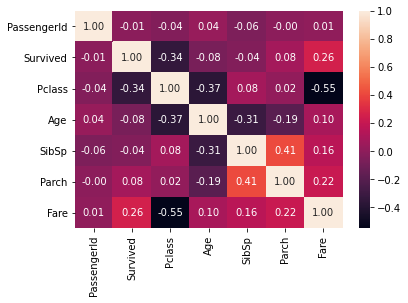

In [3]:
sns.heatmap(data = df.corr(), annot=True, fmt=".2f")
#plt.show()

* Servived(target feature)에 영향을 미치는 피쳐는 Pclass(음의 상관관계), fare(양의 상관관계)이다.
* Pclass에 영향을 미치는 피쳐는 Age, Fare이다.
* SibSp에 영향을 미치는 피쳐는 Parch이다.

In [5]:
X = df.drop("Survived", axis=1)
y = df["Survived"] 
print(X[:2])
print(y[:2])

   PassengerId  Pclass                                               Name  \
0            1       3                            Braund, Mr. Owen Harris   
1            2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   

      Sex   Age  SibSp  Parch     Ticket     Fare Cabin Embarked  
0    male  22.0      1      0  A/5 21171   7.2500   NaN        S  
1  female  38.0      1      0   PC 17599  71.2833   C85        C  
0    0
1    1
Name: Survived, dtype: int64


In [6]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
X['Sex'] = X['Sex'].apply(lambda x : 1 if x =='male' else 0)
print(X['Sex'].head())

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64


In [8]:
X['Embarked'] = X['Embarked'].apply(lambda x : 1 if x == 'C' else (2 if x == 'Q' else 3 ))
print(X['Embarked'])
#-> = 선착장 위치는 중요 변수X = 생존과 무관

0      3
1      1
2      3
3      3
4      3
      ..
886    3
887    3
888    3
889    1
890    2
Name: Embarked, Length: 891, dtype: int64


### 2. 결측처리
  - 1.삭제 2.대체값 3.예측
  
5  Age          714 non-null    float64  
10  Cabin        204 non-null    object

In [9]:
print(X.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


* Age와 Cabin을 결측 처리 해야한다.

In [10]:
#이름으로 나이 추측하기

X["Name2"] = X["Name"].str.extract("([A-Za-z]+)\.")
dict = X.groupby(by=["Name2"])[["Name2","Age"]].mean().astype(np.int32).to_dict()
print(dict['Age'])
print(X[["Name2","Name","Age"]].head(10))
fill_mean_func = lambda gname: gname.fillna(dict['Age'][gname.name])
X = X.groupby('Name2').apply(fill_mean_func)
print(X[["Name2","Name","Age"]].head(10))

{'Capt': 70, 'Col': 58, 'Countess': 33, 'Don': 40, 'Dr': 42, 'Jonkheer': 38, 'Lady': 48, 'Major': 48, 'Master': 4, 'Miss': 21, 'Mlle': 24, 'Mme': 24, 'Mr': 32, 'Mrs': 35, 'Ms': 28, 'Rev': 43, 'Sir': 49}
    Name2                                               Name   Age
0      Mr                            Braund, Mr. Owen Harris  22.0
1     Mrs  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0
2    Miss                             Heikkinen, Miss. Laina  26.0
3     Mrs       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0
4      Mr                           Allen, Mr. William Henry  35.0
5      Mr                                   Moran, Mr. James   NaN
6      Mr                            McCarthy, Mr. Timothy J  54.0
7  Master                     Palsson, Master. Gosta Leonard   2.0
8     Mrs  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  27.0
9     Mrs                Nasser, Mrs. Nicholas (Adele Achem)  14.0
    Name2                                               Name

In [12]:
# 11 12 13 --> 10
# 22 23 24 --> 20
#나이 구간화    /(나누기) %(나머지) //(몫)

X['Age_cate'] = X['Age'].apply(lambda x : int(x//10))
print(X[['Age_cate', 'Age']])
print(pd.crosstab([X['Pclass'], X['Sex'], X['Age_cate']], y).T)

     Age_cate   Age
0           2  22.0
1           3  38.0
2           2  26.0
3           3  35.0
4           3  35.0
..        ...   ...
886         2  27.0
887         1  19.0
888         2  21.0
889         2  26.0
890         3  32.0

[891 rows x 2 columns]
Pclass    1                                  ...  3                          \
Sex       0                         1        ...  0      1                    
Age_cate  0   1   2   3   4   5  6  0  1  2  ...  4  6   0   1   2    3   4   
Survived                                     ...                              
0         1   0   1   0   0   1  0  0  3  9  ...  9  0  15  38  86  128  23   
1         0  13  16  35  13  11  3  2  2  9  ...  0  1  10   4  16   15   2   

Pclass             
Sex                
Age_cate  5  6  7  
Survived           
0         6  2  2  
1         0  0  0  

[2 rows x 44 columns]


In [13]:
print(pd.crosstab(X['Embarked'], y).T)
print(pd.crosstab([X['Embarked'], X['Pclass']], y).T)

Embarked   1   2    3
Survived             
0         75  47  427
1         93  30  219
Embarked   1         2          3         
Pclass     1  2   3  1  2   3   1   2    3
Survived                                  
0         26  8  41  1  1  45  53  88  286
1         59  9  25  1  2  27  76  76   67


* 선착장 위치(Embarked)보단 객실 등급(Pclass)이 영향을 많이 준다.

In [15]:
# 병합 피쳐 : 중복된특징,
#  6   SibSp        891 non-null    int64
#  7   Parch        891 non-null    int64

X["SP"] = X["SibSp"] + X["Parch"]
print(X[["SP", "SibSp", "Parch"]])

     SP  SibSp  Parch
0     1      1      0
1     1      1      0
2     0      0      0
3     1      1      0
4     0      0      0
..   ..    ...    ...
886   0      0      0
887   0      0      0
888   3      1      2
889   0      0      0
890   0      0      0

[891 rows x 3 columns]


In [16]:
# -------------------------------------
# 4-1. box plot , scatter plot
# -------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=5)
columns = df.columns  #[....]
for i, col in enumerate(columns) :
    r = int(i / 5)
    c = i % 5
    sns.boxplot(x=col, y='Survived', data=df, ax=axes[r][c])
#plt.show()

KeyboardInterrupt: 

In [17]:
# -------------------------------------
# 4-2. IQR : 25%~75% 범위 값
# -------------------------------------
def get_outlier(df=None, column=None):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    Q1 = np.percentile(df[column].values, 25)
    Q3 = np.percentile(df[column].values, 75)
    IQR = Q3 - Q1
    IQR_weight = IQR * 1.5
    minimum = Q1 - IQR_weight
    maximum = Q3 + IQR_weight
    outlier_idx = df[column][  (df[column]<minimum) | (df[column]>maximum)  ].index
    return outlier_idx

# 함수 사용해서 이상치 값 삭제
numeric_columns = df.dtypes[df.dtypes != 'object'].index
for i, col in enumerate(numeric_columns):
    outlier_idx = get_outlier(df=df, column=col)
    print(col, outlier_idx)
    #df.drop(outlier_idx, axis=0, inplace=True)

PassengerId Int64Index([], dtype='int64')
Survived Int64Index([], dtype='int64')
Pclass Int64Index([], dtype='int64')
Age Int64Index([], dtype='int64')
SibSp Int64Index([  7,  16,  24,  27,  50,  59,  63,  68,  71,  85,  88, 119, 159,
            164, 171, 176, 180, 182, 201, 229, 233, 261, 266, 278, 324, 341,
            374, 386, 409, 480, 485, 541, 542, 634, 642, 683, 686, 726, 787,
            792, 813, 819, 824, 846, 850, 863],
           dtype='int64')
Parch Int64Index([  7,   8,  10,  13,  16,  24,  25,  27,  43,  50,
            ...
            855, 856, 858, 863, 869, 871, 879, 880, 885, 888],
           dtype='int64', length=213)
Fare Int64Index([  1,  27,  31,  34,  52,  61,  62,  72,  88, 102,
            ...
            792, 802, 820, 829, 835, 846, 849, 856, 863, 879],
           dtype='int64', length=116)


### 3. 불필요한 피쳐 삭제

0   PassengerId  891 non-null    int64

* ticket 일련번호라, Cabin은 Null이 많아서 삭제한다.
* Fare <--Pclass,SP로 유추 가능 
* "Embarked"     => 지워도 되고 안 지워도 되고
* 기존 삭제 목록들 중 데이터 분석을 통해 "Ticket", "Fare", "Cabin", "Embarked" 추가

In [19]:
print(X.shape)
X.drop("PassengerId", axis=1, inplace=True)
print(X.shape)
print(X.info())

del_col = ["SibSp", "Parch", "Name", "Name2", "Age"] 
replace_col = ["Ticket", "Fare", "Cabin", "Embarked"]

replace_col = replace_col + del_col
X.drop(replace_col, axis=1, inplace=True)
print(X.info())

(891, 14)
(891, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     891 non-null    object 
 9   Embarked  891 non-null    int64  
 10  Name2     891 non-null    object 
 11  Age_cate  891 non-null    int64  
 12  SP        891 non-null    int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 129.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Pclass    891 non-null    int64
 1   S

### 4-1. 피쳐 전처리(PreProcessing/Feature Engineering) --> Object 가공
  - 라벨인코딩, pd.getDummy()

In [20]:
print(X["Age_cate"].head())
print(X.info())

X_encoding = pd.get_dummies(data=X, columns=["Age_cate"], prefix = "OH_Age_cate")
print(X_encoding.info())
print(X_encoding.head())

0    2
1    3
2    2
3    3
4    3
Name: Age_cate, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Pclass    891 non-null    int64
 1   Sex       891 non-null    int64
 2   Age_cate  891 non-null    int64
 3   SP        891 non-null    int64
dtypes: int64(4)
memory usage: 67.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Pclass         891 non-null    int64
 1   Sex            891 non-null    int64
 2   SP             891 non-null    int64
 3   OH_Age_cate_0  891 non-null    uint8
 4   OH_Age_cate_1  891 non-null    uint8
 5   OH_Age_cate_2  891 non-null    uint8
 6   OH_Age_cate_3  891 non-null    uint8
 7   OH_Age_cate_4  891 non-null    uint8
 8   OH_Age_cate_5  891 non-null    uint8

### 4-2. 피쳐 전처리(PreProcessing/Feature Engineering) --> Numeric 가공
  - 원핫인코딩(수치형)
  - 스케일/정규화 : StandardScaler, MinMaxScaler, RobustScaler

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

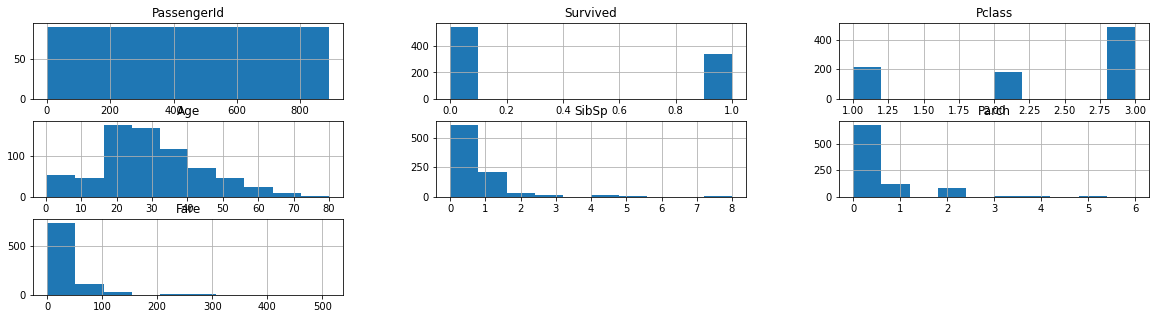

In [21]:
df.hist(figsize=(20, 5))
#plt.show()

In [22]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=121, shuffle=True)

dt_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()

models = [dt_model, knn_model, rf_model]
for model in models :
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred) 
    
    print(model.__class__)
    print(model.__str__(), ":" , score)

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
DecisionTreeClassifier() : 0.7821229050279329
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
KNeighborsClassifier() : 0.7653631284916201
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
RandomForestClassifier() : 0.7932960893854749


### 5. 분석하기 좋은 데이터가 갖춰진 상태 - 상관분석, feature_importance
  - 피쳐간 영향도, 피쳐의 중요도를 확인 할 수 있다.

<AxesSubplot:>

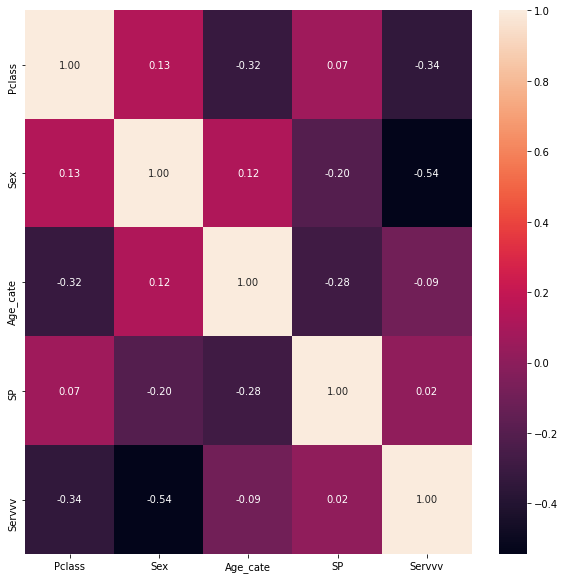

In [23]:
heat_df = X.copy()
heat_df["Servvv"] =y
plt.figure(figsize=(10,10))
sns.heatmap(data = heat_df.corr(), annot=True, fmt=".2f")
#plt.show()

### 6. 학습모델 선정 / 학습 / 평가
  - 분석 방법 : 회귀, 분류, 군집
  - 분석 모델 : RandomForest(), DecisionTreeClassifier() 등등...
  - 평가 모형 : f1, accuracy, auc, recall
  
  - --> 코딩 fit(), predict(), score()

In [25]:
X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.2, random_state=121, shuffle=True)

models = [dt_model, knn_model, rf_model]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    print(model.__class__)
    print(model.__str__(), ":", score)

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
DecisionTreeClassifier() : 0.7932960893854749
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
KNeighborsClassifier() : 0.7541899441340782
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
RandomForestClassifier() : 0.7988826815642458


* DecisionTree, KNeighbors, RandomForest 중에서는 RandomForest의 정확도가 79.9%로 가장 높았다.

### 7-1. 검증1 / 튜닝
  - 학습량 증가 : KFold, cross_var_score()
  - 학습량 증가 + (파라미터)튜닝 : GridSearchCV()

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True,  random_state=121)
kf = KFold(n_splits=5, shuffle=True, random_state=121)
accuracy_score_list = []
f1_score_list = []

for i, (idx_train, idx_test) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[idx_train], X.iloc[idx_test]
    y_train, y_test = y.iloc[idx_train], y.iloc[idx_test]

    rf_model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_score_list.append(accuracy)
    f1_score_list.append(f1)
    print(i, ":", accuracy, f1)
    
print("KFold 평균 정확도:", np.mean(accuracy_score_list))
print("KFold 평균 F1:", np.mean(f1_score_list))

0 : 0.7988826815642458 0.7352941176470588
1 : 0.8258426966292135 0.752
2 : 0.8202247191011236 0.746031746031746
3 : 0.8539325842696629 0.7833333333333332
4 : 0.797752808988764 0.76
KFold 평균 정확도: 0.819327098110602
KFold 평균 F1: 0.7553318394024275


In [27]:
#Scoring matrix

score_list = cross_val_score(rf_model, X, y, scoring="f1", cv=5, verbose=0)

print("cross_val_score 평균 F1:", np.mean(score_list))

cross_val_score 평균 F1: 0.7456262998267382


In [28]:
my_score={"acc":"accuracy", "f1":"f1"}
score_list = cross_validate(rf_model, X, y, scoring=my_score, cv=5, verbose=0)
print("score_list------->", score_list)
score_df = pd.DataFrame(score_list)
print(score_df.head(10))
print("cross_validation 평균 정확도 : " , score_df["test_acc"].mean())
print("cross_validation 평균 f1 : " , score_df["test_f1"].mean())

score_list-------> {'fit_time': array([0.36392713, 0.30318952, 0.31619549, 0.30225873, 0.32664156]), 'score_time': array([0.02792478, 0.03491092, 0.0319171 , 0.02992034, 0.03116488]), 'test_acc': array([0.78212291, 0.82022472, 0.82022472, 0.78651685, 0.85393258]), 'test_f1': array([0.71111111, 0.75      , 0.75384615, 0.67241379, 0.8030303 ])}
   fit_time  score_time  test_acc   test_f1
0  0.363927    0.027925  0.782123  0.711111
1  0.303190    0.034911  0.820225  0.750000
2  0.316195    0.031917  0.820225  0.753846
3  0.302259    0.029920  0.786517  0.672414
4  0.326642    0.031165  0.853933  0.803030
cross_validation 평균 정확도 :  0.8126043562864854
cross_validation 평균 f1 :  0.7380802722182034


In [32]:
#튜닝

my_hyper_param = {
    "n_estimators"      :[300], 
    "max_depth"         :[3,5,7,9],
    "min_samples_leaf"  :[1,3,5],
}

In [34]:
gcv_model = GridSearchCV(rf_model, param_grid=my_hyper_param, scoring="f1", refit=True, cv=5, verbose=0)

gcv_model.fit(X_train, y_train)

print("best_estimator:", gcv_model.best_estimator_)
print("best_params:",    gcv_model.best_params_)
print("best_score:" ,    gcv_model.best_score_)

best_estimator: RandomForestClassifier(max_depth=3, n_estimators=300)
best_params: {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 300}
best_score: 0.7609986012762373


<튜닝 결과>
* 파라미터 튜닝 결과:   
    'max_depth': 3,   
    'min_samples_leaf': 1,   
    'n_estimators': 300   
    에서 좋은 결과를 보였다.  
    
* best_score는 f1: accuracy: 

In [37]:
#### ↓↓↓↓문법 공부용↓↓↓↓

In [ ]:
#GridSearchCV로 scoring을 여러개 줄 경우
my_score={"acc":"accuracy", "f1":"f1"}
gcv_model = GridSearchCV(rf_model, param_grid=my_hyper_param, scoring=my_score, refit="f1", cv=5, verbose=0)
gcv_model.fit(X_train, y_train)

print("best_estimator_", gcv_model.best_estimator_)
print("best_params_",    gcv_model.best_params_)
print("best_score_" ,    gcv_model.best_score_)

#다이렉트로 빼는ver
print("GridSearchCV 평균 정확도:" , gcv_model.cv_results_["mean_test_acc"].mean()) #mean_test_(본인의 score 키값)
print("GridSearchCV 평균 F1:"    , gcv_model.cv_results_["mean_test_f1"].mean())

#데이터 프레임으로 만드는ver
gcv_df = pd.DataFrame(gcv_model.cv_results_)
print(gcv_df.info())
print("GridSearchCV 평균 정확도:" , gcv_df["mean_test_acc"].mean())
print("GridSearchCV 평균 F1:"    , gcv_df["mean_test_f1"].mean())

### 7-2. 검증2
  - Confusion Matrix, 임계치 조정
  - auc-roc curv 곡선
  - 분석 모델의 타당성 설명